In [1]:
import pandas as pd

In [2]:
team_stats = pd.read_csv('csv_files_used/team_stats.csv')

In [3]:
# to add 'points' and 'conceded' to team_stats
standings = pd.read_csv('csv_files_used/premier_league_stats_2024-25.csv')

In [4]:
standings = standings.rename(columns={"Squad":"team","Rk":"rank","W":"win","L":"loss","D":"draw","GF":"goals","GA":"conceded","Pts":"points"})

In [5]:
standings = standings.drop(columns=['goals','MP','GD','Pts/MP','xG','xGA','xGD','xGD/90','Attendance','Top Team Scorer','Goalkeeper','Notes'])

In [6]:
# to add 'salary' to team_stats
team_salary = pd.read_csv('csv_files_used/team_salary.csv')

## Imported three files:
* 'team_stats' has plenty of team stats
* 'standings' df has 'Points' and 'Conceded', they'll be added into 'team stats'
* Added 'team_salary' to see how much each team spends on their team (normalized)

## Normalized Annual Salary
* Annual money each team spends on 61 players evenly.
* Then i will drop the rest of the columns.

In [7]:
team_salary['players'].agg('mean')

np.float64(61.0)

In [8]:
# now i will divided annual by amount of players for each team
team_salary['newAnnual'] = team_salary['annual'] / team_salary['players']

In [9]:
team_salary['annual_normalized'] = (team_salary['newAnnual'] * 61)

In [10]:
team_salary['annual_normalized'] = round(team_salary['annual_normalized'] / 1e6,3)

In [11]:
team_salary.drop(columns=['players','weekly','annual','newAnnual'],inplace=True)


## Dropped
Columns dropped for 'rank','win','loss','draw','goals','last5','top_scorer','keeper'. 
Will keep conceeded and points.
Going to merge standings into team_stats to line up points and conceeded.

In [12]:
team_stats = team_stats.merge(standings,on='team',how='outer')

## Adding Annual Millions spent per team

* From 'team_salary' into 'team_stats'

In [13]:
team_stats = team_stats.merge(team_salary,on='team',how='outer')

## Dropping 
### From 'team_stats' df
* players' - Dosen't have any correlations.
* 'age' nothing to do with success here.
* 'expected goals' will drop since redundant with 'goals'.
* 'reds' and 'yellows' dont correlate with data.


In [14]:
team_stats = team_stats.drop(columns=['players','age','expected_goals','yellows','reds','expected_assists'])

In [15]:
team_stats.columns

Index(['team', 'possession', 'goals', 'assists', 'penalty_kicks',
       'penalty_kick_attempts', 'progressive_carries', 'progressive_passes',
       'rank', 'win', 'draw', 'loss', 'conceded', 'points',
       'annual_normalized'],
      dtype='object')

In [16]:
columns = ['possession','goals','annual_normalized','assists','conceded', 'penalty_kicks',
       'penalty_kick_attempts', 'progressive_carries', 'progressive_passes'
       ,'points']

In [17]:
team_stats[columns].corr().style.background_gradient(cmap='coolwarm')

,possession,goals,annual_normalized,assists,conceded,penalty_kicks,penalty_kick_attempts,progressive_carries,progressive_passes,points
possession,1.000000,0.609892,0.746470,0.623068,-0.392981,0.240899,0.287998,0.911283,0.925084,0.502695
goals,0.609892,1.000000,0.389608,0.974815,-0.706087,0.643140,0.603698,0.639954,0.805307,0.887417
annual_normalized,0.746470,0.389608,1.000000,0.426557,-0.582557,0.050619,0.011381,0.670447,0.707090,0.497320
assists,0.623068,0.974815,0.426557,1.000000,-0.698746,0.541091,0.523338,0.639672,0.805013,0.868700
conceded,-0.392981,-0.706087,-0.582557,-0.698746,1.000000,-0.482290,-0.420405,-0.442257,-0.615850,-0.908663
penalty_kicks,0.240899,0.643140,0.050619,0.541091,-0.482290,1.000000,0.930322,0.230834,0.460257,0.621819
penalty_kick_attempts,0.287998,0.603698,0.011381,0.523338,-0.420405,0.930322,1.000000,0.278873,0.465096,0.580545
progressive_carries,0.911283,0.639954,0.670447,0.639672,-0.442257,0.230834,0.278873,1.000000,0.903038,0.555286
progressive_passes,0.925084,0.805307,0.707090,0.805013,-0.615850,0.460257,0.465096,0.903038,1.000000,0.710133
points,0.502695,0.887417,0.497320,0.868700,-0.908663,0.621819,0.580545,0.555286,0.710133,1.000000


## Correlation Findings So far
* possesion and progressive_carries and progressive_passes both have very high correlation.
* 0.911283 - Carries + possesion
* 0.925084 - Passes + possesion
### Annual + Prog_carries + prog_passes
* Also a very high correlation at carries (0.670447) and passes (0.707090)
* Annual higher means higher possession too
### points + prog_carries + prog_passes
* Points have correlation with carries at (0.543832) and passes at (0.701386)
### what i want to explore is
* Since we have data on players and their positions with prog_carries and prog_passes
* lets see if certain chareractices of position or position metrics correlate with prog_passes and carries
* What if salary per position has something to do with sucesss (more points).

## Adding 'team_posseion' df into team_stats
* Will show me more catorgized correlation based on deffensive,middle,attacking touches

In [18]:
team_possession = pd.read_csv('csv_files_used/team_possession_stats.csv')

## Dropping
* Dropping duplicate columns

In [19]:
team_possession = team_possession.drop(columns=['possession'])

# Merging
* Adding stats from 'team_possession' over to 'team_stats'

In [20]:
team_stats = team_stats.merge(team_possession,on='team',how='outer')

### Check corr() again with new columns

In [21]:
columns = [ 'points','possession', 'goals', 'assists', 'penalty_kicks',
       'penalty_kick_attempts', 'progressive_carries', 'progressive_passes',
       'conceded', 'annual_normalized', 'touches',
       'deffensive_touches', 'middle_touches', 'attacking_touches',
       'attempted_take_ons', 'successful_take_ons', 'carries',
       'total_distance_carried']

In [22]:
team_stats[columns].corr().style.background_gradient(cmap='coolwarm')

,points,possession,goals,assists,penalty_kicks,penalty_kick_attempts,progressive_carries,progressive_passes,conceded,annual_normalized,touches,deffensive_touches,middle_touches,attacking_touches,attempted_take_ons,successful_take_ons,carries,total_distance_carried
points,1.000000,0.502695,0.887417,0.868700,0.621819,0.580545,0.555286,0.710133,-0.908663,0.497320,0.376739,-0.622175,0.339275,0.662261,0.061883,0.254025,0.317565,0.356896
possession,0.502695,1.000000,0.609892,0.623068,0.240899,0.287998,0.911283,0.925084,-0.392981,0.746470,0.964162,-0.099088,0.911300,0.865709,0.632106,0.643040,0.954784,0.934938
goals,0.887417,0.609892,1.000000,0.974815,0.643140,0.603698,0.639954,0.805307,-0.706087,0.389608,0.493168,-0.460896,0.421723,0.702740,0.188620,0.301506,0.454915,0.509021
assists,0.868700,0.623068,0.974815,1.000000,0.541091,0.523338,0.639672,0.805013,-0.698746,0.426557,0.493903,-0.476535,0.441823,0.693135,0.160207,0.272728,0.470719,0.513366
penalty_kicks,0.621819,0.240899,0.643140,0.541091,1.000000,0.930322,0.230834,0.460257,-0.482290,0.050619,0.184009,-0.166309,0.153323,0.265662,-0.076646,-0.036731,0.109998,0.108856
penalty_kick_attempts,0.580545,0.287998,0.603698,0.523338,0.930322,1.000000,0.278873,0.465096,-0.420405,0.011381,0.209506,-0.117222,0.173799,0.263546,-0.043384,-0.007806,0.157570,0.175158
progressive_carries,0.555286,0.911283,0.639954,0.639672,0.230834,0.278873,1.000000,0.903038,-0.442257,0.670447,0.874167,-0.346861,0.808858,0.939098,0.635673,0.708362,0.876875,0.939898
progressive_passes,0.710133,0.925084,0.805307,0.805013,0.460257,0.465096,0.903038,1.000000,-0.615850,0.707090,0.856472,-0.330097,0.776224,0.927853,0.448790,0.509584,0.838429,0.847313
conceded,-0.908663,-0.392981,-0.706087,-0.698746,-0.482290,-0.420405,-0.442257,-0.615850,1.000000,-0.582557,-0.272947,0.671882,-0.223307,-0.615454,0.061716,-0.106657,-0.222509,-0.249787
annual_normalized,0.497320,0.746470,0.389608,0.426557,0.050619,0.011381,0.670447,0.707090,-0.582557,1.000000,0.719251,-0.296499,0.674314,0.762058,0.313929,0.385168,0.702698,0.645070


In [23]:
team_stats = team_stats.sort_values(by='points',ascending=False).reset_index(drop=True)

In [24]:
team_stats.columns

Index(['team', 'possession', 'goals', 'assists', 'penalty_kicks',
       'penalty_kick_attempts', 'progressive_carries', 'progressive_passes',
       'rank', 'win', 'draw', 'loss', 'conceded', 'points',
       'annual_normalized', 'touches', 'deffensive_touches', 'middle_touches',
       'attacking_touches', 'attempted_take_ons', 'successful_take_ons',
       'carries', 'total_distance_carried'],
      dtype='object')

# New DF
* Since I am finding correlation between points and deffensive metrics
* I'll take' player_possesion' stats to organize them by per game stats and their posistion.
* Then ill get the 'player salary for each player to have that average too'

In [25]:
player_possession = pd.read_csv('csv_files_used/player_possession_stats.csv') 
player_stats = pd.read_csv('csv_files_used/player_stats.csv')
player_salaries = pd.read_csv('csv_files_used/player_salaries.csv')

In [26]:
player_stats = player_stats.drop(columns=['nation','team','position','age'])

In [27]:
player_stats.columns

Index(['name', 'born', 'played', 'starts', 'minutes', 'goals', 'assists',
       'penalty_kicks', 'penalty_kick_attempts', 'yellow', 'red',
       'expected_goals', 'progressive_carries', 'progressive_passes',
       'received_progressive_passes'],
      dtype='object')

In [28]:
player_stats = player_stats.rename(columns={'name':'player'})

In [29]:
player_stats

,player,born,played,starts,minutes,goals,assists,penalty_kicks,penalty_kick_attempts,yellow,red,expected_goals,progressive_carries,progressive_passes,received_progressive_passes
0,Max Aarons,2000.0,3,1,86,0,0,0,0,0,0,0.0,1,8,3
1,Joshua Acheampong,2006.0,4,2,170,0,0,0,0,1,0,0.2,0,8,0
2,Tyler Adams,1999.0,27,20,1875,0,3,0,0,7,0,1.6,13,71,10
3,Tosin Adarabioyo,1997.0,21,14,1319,1,1,0,0,3,0,0.9,5,39,1
4,Simon Adingra,2002.0,28,11,1052,2,2,0,0,0,0,2.4,50,18,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,Ashley Young,1985.0,31,18,1785,1,3,0,0,6,1,0.3,23,89,32
567,Illia Zabarnyi,2002.0,35,34,3019,0,0,0,0,4,1,1.1,26,134,4
568,Oleksandr Zinchenko,1996.0,14,4,458,0,1,0,0,1,0,0.3,10,37,12
569,Joshua Zirkzee,2001.0,32,14,1402,3,1,0,0,2,0,4.8,14,44,69


# Drop Col
* 'player_salaries'
* Will change posistion later if theyre hybrid players, merge only on name


# Ran Script
* Ran file 'match_salaries'
* It took salary data and matched it correctly with the names in 'team_possesion'
* Issue was: Many names had different letter formats, used fuzzy to fix it.

In [30]:
stats_per_game = pd.read_csv('csv_files_used/player_possession_with_salaries.csv')

In [31]:
stats_per_game.drop(columns=['nation','age','90s','touches'],inplace=True)

In [32]:
stats_per_game.value_counts().sum()

np.int64(571)

In [33]:
stats_per_game = stats_per_game.drop_duplicates(subset=['player'],keep='first')

In [34]:
stats_per_game = stats_per_game.merge(player_stats,on='player',how='left')

In [35]:
stats_per_game = stats_per_game.drop(columns=['yellow', 'red','born','starts','played'])

In [36]:
stats_per_game.value_counts().sum()

np.int64(569)

In [37]:
stats_per_game = stats_per_game[stats_per_game['position'] != 'GK'].copy()
print(f"\nRemaining positions:\n{stats_per_game['position'].value_counts()}")


Remaining positions:
position
DF       185
MF       112
FW        81
FW,MF     64
MF,FW     44
DF,MF     17
MF,DF     13
FW,DF      6
DF,FW      6
Name: count, dtype: int64


In [38]:
POSITION_MAP = {
    "FW,MF": "FW",
    "MF,FW": "MF",
    "DF,FW": "DF",
    "FW,DF": "FW",   # optional safety
    "DF,MF": "DF",
    "MF,DF": "MF",
}

# Normalize position column
stats_per_game["position"] = (
    stats_per_game["position"]
    .map(POSITION_MAP)
    .fillna(stats_per_game["position"])
)

In [39]:
stats_per_game.drop(columns='player',inplace=True)

In [40]:
position_sorted_by_team = stats_per_game.groupby(by=['team','position']).agg('sum')

In [41]:
position_sorted_by_team.reset_index(inplace=True)

In [42]:
position_sorted_by_team.columns

Index(['team', 'position', 'deffensive_touches', 'middle_touches',
       'attacking_touches', 'attempted_take_ons', 'successful_take_ons',
       'takeons_tackled', 'carries', 'total_distance_carried', 'received',
       'Annual', 'minutes', 'goals', 'assists', 'penalty_kicks',
       'penalty_kick_attempts', 'expected_goals', 'progressive_carries',
       'progressive_passes', 'received_progressive_passes'],
      dtype='object')

## Seperating by Team
* Since I have three positions I'll sort them by points to see if i can find some interesting patterns.
* First four lines of code i wrote to test and the last piece is to clean it up.

In [43]:
#defense_df = position_sorted_by_team[position_sorted_by_team['position'] == 'DF']

In [44]:
#defense_df = defense_df.merge(standings[['team','points']],on='team',how='outer')

In [45]:
#defense_df = defense_df.sort_values(by='points',ascending=False).reset_index(col_level=0)

In [46]:
#defense_df = defense_df.drop(columns='index')

In [47]:
defense_df = (
    position_sorted_by_team
        .loc[position_sorted_by_team['position'] == 'DF']
        .merge(standings[['team', 'points']], on='team', how='left')
        .sort_values(by='points', ascending=False)
        .reset_index(drop=True)
)

In [48]:
defense_df = pd.merge(defense_df,team_stats[['team','conceded']],how='left')

In [49]:
#midfield_df = position_sorted_by_team[position_sorted_by_team['position'] == 'MF']

In [50]:
#midfield_df = midfield_df.merge(standings[['team','points']],on='team',how='outer')

In [51]:
#midfield_df = midfield_df.sort_values(by='points',ascending=False).reset_index(col_level=0)

In [52]:
#midfield_df = midfield_df.drop(columns='index')

In [53]:
midfield_df = (position_sorted_by_team.loc[position_sorted_by_team['position'] == 'MF']
               .merge(standings[['team','points']],on='team',how='left')
               .sort_values(by='points',ascending=False)
               .reset_index(drop=True)
              )

In [54]:
midfield_df = pd.merge(midfield_df,team_stats[['team','conceded']],how='left')

In [55]:
#forward_df = position_sorted_by_team[position_sorted_by_team['position'] == 'FW']

In [56]:
#forward_df = forward_df.merge(standings[['team','points']],on='team',how='outer')

In [57]:
#forward_df = forward_df.sort_values(by='points',ascending=False).reset_index(col_level=0)

In [58]:
#forward_df = forward_df.drop(columns='index')

In [59]:
forward_df = (position_sorted_by_team.loc[position_sorted_by_team['position'] == 'FW']
              .merge(standings[['team','points']],on='team',how='left')
              .sort_values(by='points',ascending=False)
              .reset_index(drop=True)
             )

In [60]:
forward_df = pd.merge(forward_df,team_stats[['team','conceded']],how='left')

In [61]:
df_columns = ['points','Annual','expected_goals','conceded','carries','deffensive_touches','attempted_take_ons',
              'assists','successful_take_ons','takeons_tackled','progressive_carries',
              'progressive_passes','received_progressive_passes','total_distance_carried', 'middle_touches',
       'attacking_touches',
             ]

In [62]:
threshold = 0.4

In [63]:
defense_corr = defense_df[df_columns].corr()

In [64]:
defense_corr.where(defense_corr.abs() >= threshold).style.background_gradient(cmap='RdPu',vmin=-1,vmax=1)

,points,Annual,expected_goals,conceded,carries,deffensive_touches,attempted_take_ons,assists,successful_take_ons,takeons_tackled,progressive_carries,progressive_passes,received_progressive_passes,total_distance_carried,middle_touches,attacking_touches
points,1.000000,0.424988,nan,-0.908663,nan,-0.514604,nan,nan,nan,nan,nan,0.491408,nan,nan,nan,nan
Annual,0.424988,1.000000,0.512576,-0.485624,0.660178,nan,nan,nan,nan,nan,nan,0.600423,nan,0.575927,0.652752,0.617227
expected_goals,nan,0.512576,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
conceded,-0.908663,-0.485624,nan,1.000000,nan,0.580530,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carries,nan,0.660178,nan,nan,1.000000,nan,nan,nan,nan,nan,0.700750,0.789309,0.506877,0.951412,0.934611,0.818826
deffensive_touches,-0.514604,nan,nan,0.580530,nan,1.000000,nan,nan,nan,0.435268,nan,nan,nan,nan,nan,nan
attempted_take_ons,nan,nan,nan,nan,nan,nan,1.000000,nan,0.981332,0.965374,0.603441,nan,0.666824,nan,nan,nan
assists,nan,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,0.408598,nan,nan,nan
successful_take_ons,nan,nan,nan,nan,nan,nan,0.981332,nan,1.000000,0.911058,0.614233,nan,0.660974,nan,nan,nan
takeons_tackled,nan,nan,nan,nan,nan,0.435268,0.965374,nan,0.911058,1.000000,0.574481,nan,0.664481,nan,nan,nan


In [65]:
mf_columns = ['points','Annual','expected_goals','conceded','assists','deffensive_touches', 'middle_touches',
       'attacking_touches','attempted_take_ons','successful_take_ons',
              'takeons_tackled','carries','total_distance_carried','received','progressive_carries',
              'progressive_passes', 'received_progressive_passes'
             ]

In [66]:
midfield_corr = midfield_df[mf_columns].corr()

In [67]:
midfield_corr.where(midfield_corr.abs() >= threshold).style.background_gradient(cmap='RdPu',vmin=-1,vmax=1)

,points,Annual,expected_goals,conceded,assists,deffensive_touches,middle_touches,attacking_touches,attempted_take_ons,successful_take_ons,takeons_tackled,carries,total_distance_carried,received,progressive_carries,progressive_passes,received_progressive_passes
points,1.000000,nan,nan,-0.908663,0.500562,-0.483837,nan,nan,nan,-0.409971,-0.408540,nan,nan,nan,nan,0.533132,nan
Annual,nan,1.000000,0.613902,nan,0.423683,nan,0.687166,0.822477,nan,nan,nan,0.821569,0.720331,0.845946,0.630221,0.676607,0.681498
expected_goals,nan,0.613902,1.000000,nan,0.686302,nan,0.734616,0.687716,0.480723,nan,0.514533,0.697482,0.647726,0.678349,0.688219,0.718610,0.779750
conceded,-0.908663,nan,nan,1.000000,-0.492473,0.493676,nan,nan,nan,0.449469,nan,nan,nan,nan,nan,-0.521324,nan
assists,0.500562,0.423683,0.686302,-0.492473,1.000000,nan,0.468220,0.692051,nan,nan,nan,0.586478,0.569182,0.531369,0.642075,0.755259,0.703977
deffensive_touches,-0.483837,nan,nan,0.493676,nan,1.000000,0.517399,nan,0.447320,0.403433,0.480264,nan,nan,nan,nan,nan,nan
middle_touches,nan,0.687166,0.734616,nan,0.468220,0.517399,1.000000,0.652017,0.448199,nan,0.463050,0.837365,0.729794,0.883884,0.659846,0.643490,0.696441
attacking_touches,nan,0.822477,0.687716,nan,0.692051,nan,0.652017,1.000000,nan,nan,0.428304,0.905781,0.891229,0.876629,0.838973,0.793429,0.886137
attempted_take_ons,nan,nan,0.480723,nan,nan,0.447320,0.448199,nan,1.000000,0.969050,0.963746,0.444627,0.589613,nan,0.674563,nan,0.603567
successful_take_ons,-0.409971,nan,nan,0.449469,nan,0.403433,nan,nan,0.969050,1.000000,0.889500,nan,0.480058,nan,0.575082,nan,0.468717


In [68]:
fw_columns = ['points','Annual','expected_goals','conceded','assists','deffensive_touches', 'middle_touches',
       'attacking_touches','attempted_take_ons','successful_take_ons',
              'takeons_tackled','carries','total_distance_carried','received','progressive_carries',
              'progressive_passes', 'received_progressive_passes'
             ]

In [69]:
forward_corr = forward_df[fw_columns].corr()

In [70]:
forward_corr.where(forward_corr.abs() >= threshold).style.background_gradient(cmap='RdPu',vmin=-1,vmax=1)

,points,Annual,expected_goals,conceded,assists,deffensive_touches,middle_touches,attacking_touches,attempted_take_ons,successful_take_ons,takeons_tackled,carries,total_distance_carried,received,progressive_carries,progressive_passes,received_progressive_passes
points,1.000000,0.534291,0.718863,-0.908663,0.695607,nan,nan,0.639888,nan,0.461125,nan,0.505352,0.531518,0.528704,0.639748,0.555596,0.688472
Annual,0.534291,1.000000,0.437033,-0.583371,0.581184,nan,nan,0.611526,0.617933,0.603013,0.528138,0.559579,0.585906,0.562043,0.661264,0.462523,0.678966
expected_goals,0.718863,0.437033,1.000000,-0.602265,0.822578,0.425870,0.607683,0.832365,0.616674,0.650244,0.567117,0.785995,0.772309,0.787928,0.758490,0.812972,0.886589
conceded,-0.908663,-0.583371,-0.602265,1.000000,-0.511351,nan,nan,-0.588594,nan,-0.410068,nan,-0.454408,-0.462098,-0.482982,-0.557397,-0.493278,-0.595241
assists,0.695607,0.581184,0.822578,-0.511351,1.000000,nan,0.602299,0.841509,0.658136,0.665733,0.586145,0.818890,0.813035,0.818862,0.828657,0.846111,0.905428
deffensive_touches,nan,nan,0.425870,nan,nan,1.000000,0.869349,0.590966,0.590237,0.523556,0.625414,0.681428,0.623618,0.684777,0.468116,0.613002,0.449555
middle_touches,nan,nan,0.607683,nan,0.602299,0.869349,1.000000,0.794112,0.781704,0.723082,0.812417,0.891755,0.833188,0.895196,0.682921,0.830237,0.691448
attacking_touches,0.639888,0.611526,0.832365,-0.588594,0.841509,0.590966,0.794112,1.000000,0.863317,0.878135,0.776164,0.973076,0.974149,0.973322,0.946520,0.895787,0.958946
attempted_take_ons,nan,0.617933,0.616674,nan,0.658136,0.590237,0.781704,0.863317,1.000000,0.965882,0.946499,0.881414,0.912300,0.876145,0.883229,0.692773,0.818237
successful_take_ons,0.461125,0.603013,0.650244,-0.410068,0.665733,0.523556,0.723082,0.878135,0.965882,1.000000,0.844704,0.867118,0.918734,0.865720,0.907514,0.703756,0.817499


# Whats been done so far
* For Each position i checked correltion for points,annual,goals,assists
* This helped me better understand other staticits and how they correlate with those main stats that correlate with success
* the scale was 0.4 > and -0.4 <. to better see the main correlation.


## Whats next
* Will group these stats into buckets, again per team to see what correlates with the points
* Bucket 1: Defensive - (defense_touches,takeons_tackled)
* Bucket 2: Ball Progression - (prog_passes,prog,carries,received_prog_passes)
* Bucket 3: Attacking Involvement - (attacking_touches,expected_goals,assists,goals)
* Bucket 4: Ball Carrying & Territory Gain - (carries,total_distance_carried)
* Bucket 5: Central Connectivity / Control - (middle_touches,received)

In [71]:
per90Cols = ['deffensive_touches','middle_touches','attacking_touches','attempted_take_ons','successful_take_ons',
 'takeons_tackled','carries','total_distance_carried','received','goals','assists','expected_goals',
 'progressive_carries','progressive_passes','received_progressive_passes','Annual']

defense_per_90 = defense_df.copy()

for col in per90Cols:
    defense_per_90[col] = (defense_per_90[col] / defense_per_90['minutes']) * 90

In [72]:
midfield_per_90 = midfield_df.copy()

for cols in per90Cols:
    midfield_per_90[cols] = (midfield_per_90[cols] / midfield_per_90['minutes']) * 90

In [73]:
forward_per_90 = forward_df.copy()

for cols in per90Cols:
    forward_per_90[cols] = (forward_per_90[cols] / forward_per_90['minutes']) * 90

In [74]:
defense_per_90['defensive_involvement_defense'] = (defense_per_90['deffensive_touches'] + defense_per_90['takeons_tackled'])
defense_per_90['ball_progression_defense'] = (
    defense_per_90['progressive_passes'] +
    defense_per_90['progressive_carries'] +
    defense_per_90['received_progressive_passes']
)
defense_per_90['attacking_involvement_defense'] = (
    defense_per_90['attacking_touches'] +
    defense_per_90['expected_goals'] +
    defense_per_90['goals'] +
    defense_per_90['assists']
)
defense_per_90['ball_carrying_defense'] = (
    defense_per_90['carries'] +
    defense_per_90['total_distance_carried']
)
defense_per_90['central_connectivity_defense'] = (
    defense_per_90['middle_touches'] +
    defense_per_90['received']
)

In [75]:
midfield_per_90['defensive_involvement_midfield'] = (midfield_per_90['deffensive_touches'] + midfield_per_90['takeons_tackled'])
midfield_per_90['ball_progression_midfield'] = (
    midfield_per_90['progressive_passes'] +
    midfield_per_90['progressive_carries'] +
    midfield_per_90['received_progressive_passes']
)
midfield_per_90['attacking_involvement_midfield'] = (
    midfield_per_90['attacking_touches'] +
    midfield_per_90['expected_goals'] +
    midfield_per_90['goals'] +
    midfield_per_90['assists']
)
midfield_per_90['ball_carrying_midfield'] = (
    midfield_per_90['carries'] +
    midfield_per_90['total_distance_carried']
)
midfield_per_90['central_connectivity_midfield'] = (
    midfield_per_90['middle_touches'] +
    midfield_per_90['received']
)

In [76]:
forward_per_90['defensive_involvement_forward'] = (forward_per_90['deffensive_touches'] + forward_per_90['takeons_tackled'])
forward_per_90['ball_progression_forward'] = (
    forward_per_90['progressive_passes'] +
    forward_per_90['progressive_carries'] +
    forward_per_90['received_progressive_passes']
)
forward_per_90['attacking_involvement_forward'] = (
    forward_per_90['attacking_touches'] +
    forward_per_90['expected_goals'] +
    forward_per_90['goals'] +
    forward_per_90['assists']
)
forward_per_90['ball_carrying_forward'] = (
    forward_per_90['carries'] +
    forward_per_90['total_distance_carried']
)
forward_per_90['central_connectivity_forward'] = (
    forward_per_90['middle_touches'] +
    forward_per_90['received']
)

In [77]:
defense_per_90 = defense_per_90.rename(columns={'Annual':'pay_per_90'})

In [78]:
midfield_per_90 = midfield_per_90.rename(columns={'Annual':'pay_per_90'})


In [79]:
forward_per_90 = forward_per_90.rename(columns={'Annual':'pay_per_90'})

In [80]:
defense_per_90.columns

Index(['team', 'position', 'deffensive_touches', 'middle_touches',
       'attacking_touches', 'attempted_take_ons', 'successful_take_ons',
       'takeons_tackled', 'carries', 'total_distance_carried', 'received',
       'pay_per_90', 'minutes', 'goals', 'assists', 'penalty_kicks',
       'penalty_kick_attempts', 'expected_goals', 'progressive_carries',
       'progressive_passes', 'received_progressive_passes', 'points',
       'conceded', 'defensive_involvement_defense', 'ball_progression_defense',
       'attacking_involvement_defense', 'ball_carrying_defense',
       'central_connectivity_defense'],
      dtype='object')

In [81]:
df_columns = ['points','defensive_involvement_defense', 'ball_progression_defense',
       'attacking_involvement_defense', 'ball_carrying_defense',
       'central_connectivity_defense']

In [82]:
print(defense_per_90[df_columns].corr())

                                 points  defensive_involvement_defense  \
points                         1.000000                      -0.282256   
defensive_involvement_defense -0.282256                       1.000000   
ball_progression_defense       0.524598                       0.112334   
attacking_involvement_defense  0.488103                      -0.017826   
ball_carrying_defense          0.320119                       0.325182   
central_connectivity_defense   0.381859                       0.326728   

                               ball_progression_defense  \
points                                         0.524598   
defensive_involvement_defense                  0.112334   
ball_progression_defense                       1.000000   
attacking_involvement_defense                  0.910760   
ball_carrying_defense                          0.898540   
central_connectivity_defense                   0.821446   

                               attacking_involvement_defense  \
poi

In [83]:
mf_columns = ['points','defensive_involvement_midfield', 'ball_progression_midfield',
       'attacking_involvement_midfield', 'ball_carrying_midfield',
       'central_connectivity_midfield']

In [84]:
print(midfield_per_90[mf_columns].corr())

                                  points  defensive_involvement_midfield  \
points                          1.000000                       -0.512120   
defensive_involvement_midfield -0.512120                        1.000000   
ball_progression_midfield       0.482220                       -0.427632   
attacking_involvement_midfield  0.552723                       -0.505029   
ball_carrying_midfield          0.277533                       -0.307276   
central_connectivity_midfield   0.403962                       -0.071427   

                                ball_progression_midfield  \
points                                           0.482220   
defensive_involvement_midfield                  -0.427632   
ball_progression_midfield                        1.000000   
attacking_involvement_midfield                   0.898280   
ball_carrying_midfield                           0.891404   
central_connectivity_midfield                    0.684368   

                                attacki

In [85]:
fw_columns = ['points','defensive_involvement_forward', 'ball_progression_forward',
       'attacking_involvement_forward', 'ball_carrying_forward',
       'central_connectivity_forward']

In [86]:
print(forward_per_90[fw_columns].corr())

                                 points  defensive_involvement_forward  \
points                         1.000000                      -0.265811   
defensive_involvement_forward -0.265811                       1.000000   
ball_progression_forward       0.719617                       0.045554   
attacking_involvement_forward  0.685996                       0.186399   
ball_carrying_forward          0.463489                       0.353688   
central_connectivity_forward   0.338293                       0.449642   

                               ball_progression_forward  \
points                                         0.719617   
defensive_involvement_forward                  0.045554   
ball_progression_forward                       1.000000   
attacking_involvement_forward                  0.936305   
ball_carrying_forward                          0.888048   
central_connectivity_forward                   0.681615   

                               attacking_involvement_forward  \
poi

In [87]:
defense_per_90 = defense_per_90.merge(standings[['team','rank']],on='team')

In [88]:
midfield_per_90 = midfield_per_90.merge(standings[['team','rank']],on='team')

In [89]:
forward_per_90 = forward_per_90.merge(standings[['team','rank']],on='team')

In [90]:
bucket_cols = [
    'defensive_involvement_forward',
    'ball_progression_forward',
    'attacking_involvement_forward',
    'ball_carrying_forward',
    'central_connectivity_forward'
]

In [91]:
forward_per_90[bucket_cols + ['rank']].corr(method='spearman')['rank']

defensive_involvement_forward    0.302256
ball_progression_forward        -0.778947
attacking_involvement_forward   -0.784962
ball_carrying_forward           -0.676692
central_connectivity_forward    -0.494737
rank                             1.000000
Name: rank, dtype: float64

In [92]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import plotly.graph_objects as go

In [93]:
bucket_cols = [
    'defensive_involvement_defense',
    'ball_progression_defense',
    'attacking_involvement_defense',
    'ball_carrying_defense',
    'central_connectivity_defense'
]

In [94]:
bucket_cols = [
    'defensive_involvement_midfield',
    'ball_progression_midfield',
    'attacking_involvement_midfield',
    'ball_carrying_midfield',
    'central_connectivity_midfield'
]

In [95]:
midfield_per_90[bucket_cols + ['rank']].corr(method='spearman')['rank']

defensive_involvement_midfield    0.590977
ball_progression_midfield        -0.514286
attacking_involvement_midfield   -0.660150
ball_carrying_midfield           -0.341353
central_connectivity_midfield    -0.403008
rank                              1.000000
Name: rank, dtype: float64

In [96]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [97]:
# Assuming your dataframes are named: team_stats, defense_df, midfield_df, forward_df
# Merge them into one 'master_df' for easy plotting
master_df = team_stats.merge(defense_per_90[['team', 'defensive_involvement_defense',
    'ball_progression_defense',
    'attacking_involvement_defense',
    'ball_carrying_defense',
    'central_connectivity_defense']], on='team').sort_values('rank',ascending=True)
master_df = master_df.merge(midfield_per_90[['team', 'defensive_involvement_midfield',
    'ball_progression_midfield',
    'attacking_involvement_midfield',
    'ball_carrying_midfield',
    'central_connectivity_midfield']], on='team').sort_values('rank',ascending=True)
master_df = master_df.merge(forward_per_90[['team', 'defensive_involvement_forward',
    'ball_progression_forward',
    'attacking_involvement_forward',
    'ball_carrying_forward',
    'central_connectivity_forward']], on='team').sort_values('rank',ascending=True)

# Add the Tier group
master_df['tier'] = pd.cut(master_df['rank'], bins=[-1, 7, 15, 21], labels=['Top 7', 'Mid 8-14', 'Bottom 5'])

In [98]:
master_df

,team,possession,goals,assists,penalty_kicks,penalty_kick_attempts,progressive_carries,progressive_passes,rank,win,...,ball_progression_midfield,attacking_involvement_midfield,ball_carrying_midfield,central_connectivity_midfield,defensive_involvement_forward,ball_progression_forward,attacking_involvement_forward,ball_carrying_forward,central_connectivity_forward,tier
0,Liverpool,57.4,84,64,9,9,801,1846,1,25,...,10.603548,20.307270,208.799653,79.422484,4.841367,17.626602,26.579927,202.559487,45.512508,Top 7
1,Arsenal,56.8,65,53,2,2,830,1764,2,20,...,12.273138,23.280977,246.168224,75.076877,5.548466,16.805855,27.272778,202.861030,43.517876,Top 7
2,Manchester City,61.6,69,51,2,3,1112,1890,3,21,...,13.276699,32.550971,308.673139,92.597087,4.171102,17.782682,30.473582,262.335454,45.998961,Top 7
3,Chelsea,57.3,60,46,4,5,848,1573,4,20,...,11.154559,19.971136,229.252072,79.538762,6.058402,16.081967,25.255328,227.148566,46.014344,Top 7
4,Newcastle Utd,50.9,66,50,5,6,727,1541,5,20,...,9.985389,17.193454,208.123904,68.372297,6.005595,14.995337,23.378924,199.201119,45.657445,Top 7
5,Aston Villa,51.0,56,45,3,6,709,1326,6,19,...,8.678043,14.652755,190.741160,73.754112,6.542187,11.790315,18.860909,163.842237,39.262107,Top 7
6,Nott'ham Forest,40.9,57,42,3,3,610,1079,7,19,...,8.000601,16.181600,157.269994,61.352977,5.561854,10.583528,19.653551,149.209737,36.562187,Top 7
7,Brighton,52.0,60,40,6,6,798,1478,8,16,...,8.908703,16.844848,195.405232,62.005339,6.517662,13.869959,23.821819,200.059394,44.404501,Mid 8-14
8,Bournemouth,48.1,55,39,6,7,732,1438,9,15,...,9.089477,16.928930,175.402107,59.462546,6.829426,12.808302,23.669508,191.399055,43.911795,Mid 8-14
9,Brentford,47.8,64,43,5,6,579,1318,10,16,...,8.828386,15.929133,171.383920,62.196776,7.118363,11.926991,21.436726,159.560841,38.389381,Mid 8-14


In [99]:
pd.set_option("display.max_columns",None)

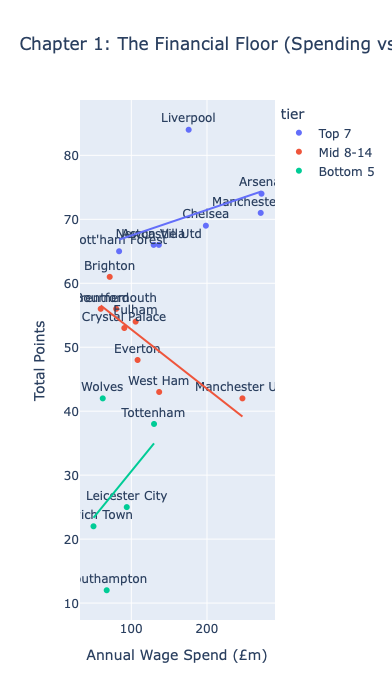

In [101]:
fig1 = px.scatter(master_df, x="annual_normalized", y="points", 
                 text="team", color="tier", trendline="ols",
                 title="Chapter 1: The Financial Floor (Spending vs. Points)",
                 labels={"annual_normalized": "Annual Wage Spend (£m)", "points": "Total Points"},
                 width=1300,height=700)
fig1.update_traces(textposition='top center')
fig1.show()

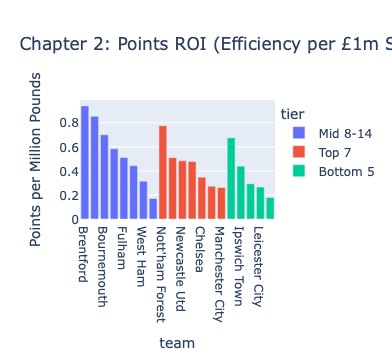

In [102]:
master_df['roi'] = master_df['points'] / master_df['annual_normalized']
fig2 = px.bar(master_df.sort_values("roi", ascending=False), 
             x="team", y="roi", color="tier",text='annual_normalized',
             title="Chapter 2: Points ROI (Efficiency per £1m Spent)",
             labels={"roi": "Points per Million Pounds"})

fig2.update_traces(textangle=0)
fig2.show()

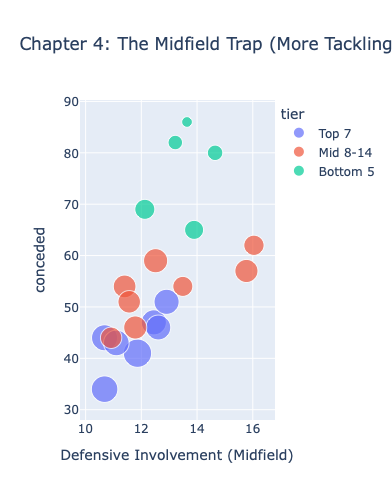

In [103]:
fig4 = px.scatter(master_df, x="defensive_involvement_midfield", y="conceded", 
                 color="tier", hover_name="team",width=1250,height=500,size='points',
                 title="Chapter 4: The Midfield Trap (More Tackling = Fewer Points?)",
                 labels={"defensive_involvement_midfield": "Defensive Involvement (Midfield)"})

fig4.update_traces(textposition='top right')
fig4.show()

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

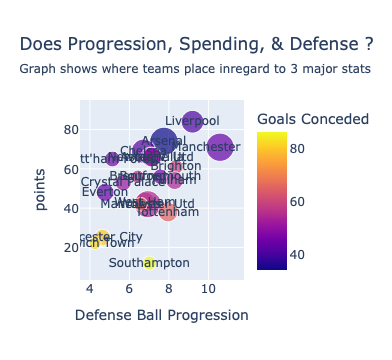

In [105]:
fig_master1 = px.scatter(master_df, x='ball_progression_defense', y='points', 
                         color='conceded', size='annual_normalized',
                        hover_name='team', text='team',
                        title='Does Progression, Spending, & Defense ?',
                         subtitle='Graph shows where teams place inregard to 3 major stats',
                        labels={'ball_progression_defense': 'Defense Ball Progression', 'conceded': 'Goals Conceded'})

fig_master1.show()

In [106]:
buckets = ['defensive_involvement', 'ball_progression', 'attacking_involvement', 'ball_carrying', 'central_connectivity']
positions = ['defense', 'midfield', 'forward']

# Create a matrix for the heatmap
heatmap_data = []

for bucket in buckets:
    row = []
    for pos in positions:
        col_name = f"{bucket}_{pos}"
        if col_name in master_df.columns:
            # Calculate correlation with points
            corr = master_df[col_name].corr(master_df['points'])
            row.append(corr)
        else:
            row.append(0)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=buckets, columns=['Defense', 'Midfield', 'Forward'])

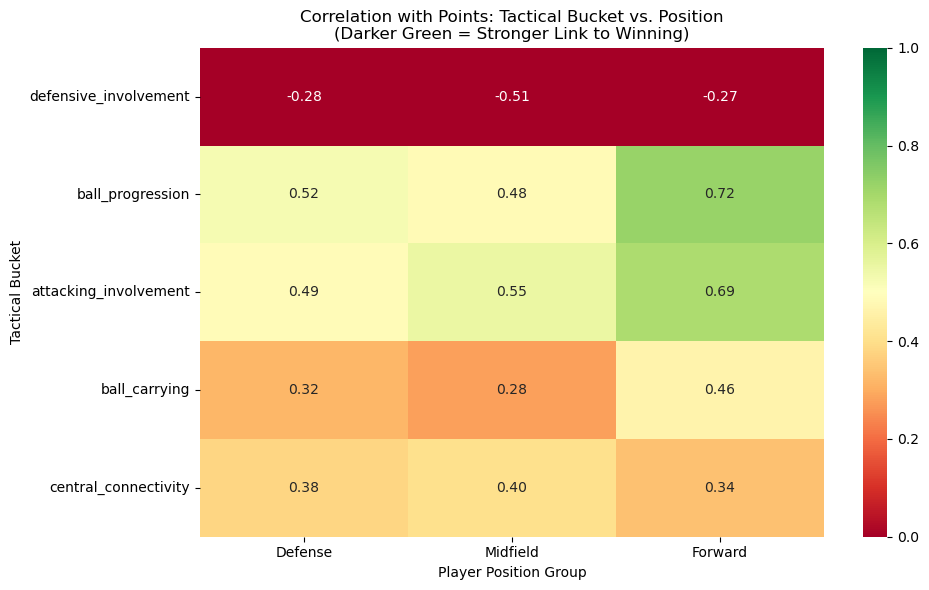

In [107]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', fmt=".2f", vmin=0, vmax=1)
plt.title('Correlation with Points: Tactical Bucket vs. Position\n(Darker Green = Stronger Link to Winning)')
plt.ylabel('Tactical Bucket')
plt.xlabel('Player Position Group')
plt.tight_layout()
plt.show()

In [108]:
print(heatmap_df)

                        Defense  Midfield   Forward
defensive_involvement -0.282256 -0.512120 -0.265811
ball_progression       0.524598  0.482220  0.719617
attacking_involvement  0.488103  0.552723  0.685996
ball_carrying          0.320119  0.277533  0.463489
central_connectivity   0.381859  0.403962  0.338293


In [109]:
master_df['defensive_involvement_df_mf'] = (master_df['defensive_involvement_defense'] + master_df['defensive_involvement_midfield']) / 2

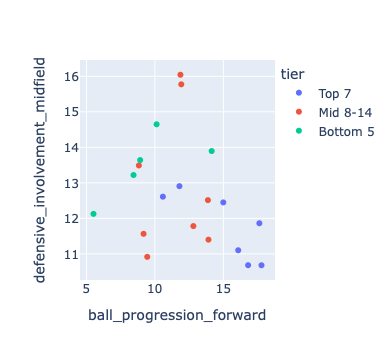

In [110]:
fig = px.scatter(master_df,x='ball_progression_forward',y='defensive_involvement_midfield',
          color='tier',hover_name='team')


fig.show()

In [111]:
master_df.head()

,team,possession,goals,assists,penalty_kicks,penalty_kick_attempts,progressive_carries,progressive_passes,rank,win,draw,loss,conceded,points,annual_normalized,touches,deffensive_touches,middle_touches,attacking_touches,attempted_take_ons,successful_take_ons,carries,total_distance_carried,defensive_involvement_defense,ball_progression_defense,attacking_involvement_defense,ball_carrying_defense,central_connectivity_defense,defensive_involvement_midfield,ball_progression_midfield,attacking_involvement_midfield,ball_carrying_midfield,central_connectivity_midfield,defensive_involvement_forward,ball_progression_forward,attacking_involvement_forward,ball_carrying_forward,central_connectivity_forward,tier,roi,defensive_involvement_df_mf
0,Liverpool,57.4,84,64,9,9,801,1846,1,25,9,4,41,84,175.795,25092,7133,11187,6995,661,295,14444,73791,28.926102,9.194961,13.692195,258.820863,94.749578,11.861743,10.603548,20.307270,208.799653,79.422484,4.841367,17.626602,26.579927,202.559487,45.512508,Top 7,0.477829,20.393923
1,Arsenal,56.8,65,53,2,2,830,1764,2,20,14,4,34,74,272.028,23363,5960,10107,7471,706,310,13816,73408,21.263125,7.747838,12.845429,212.450587,84.267295,10.681339,12.273138,23.280977,246.168224,75.076877,5.548466,16.805855,27.272778,202.861030,43.517876,Top 7,0.272031,15.972232
2,Manchester City,61.6,69,51,2,3,1112,1890,3,21,8,9,44,71,270.993,27459,6350,11762,9571,780,370,17678,101274,22.728305,10.588235,19.901157,338.427588,103.889874,10.679612,13.276699,32.550971,308.673139,92.597087,4.171102,17.782682,30.473582,262.335454,45.998961,Top 7,0.261999,16.703958
3,Chelsea,57.3,60,46,4,5,848,1573,4,20,9,9,43,69,198.519,24671,7379,11139,6367,769,322,14242,76825,29.104141,6.715182,10.726223,233.209536,92.544542,11.101902,11.154559,19.971136,229.252072,79.538762,6.058402,16.081967,25.255328,227.148566,46.014344,Top 7,0.347574,20.103021
4,Newcastle Utd,50.9,66,50,5,6,727,1541,5,20,6,12,47,66,136.402,22350,7319,9347,5905,644,277,12632,68484,29.635135,7.087838,10.923649,215.452703,74.013514,12.448860,9.985389,17.193454,208.123904,68.372297,6.005595,14.995337,23.378924,199.201119,45.657445,Top 7,0.483864,21.041998


In [112]:
master_df['progressive_attack_score'] = (
    master_df['ball_progression_forward'] +
    master_df['attacking_involvement_forward'] +
    master_df['ball_progression_midfield'] +
    master_df['attacking_involvement_midfield']
)

In [113]:
master_df['control_index'] = (
    master_df['central_connectivity_midfield'] +
    master_df['ball_progression_midfield'] +
    master_df['ball_progression_defense']
)

In [114]:
master_df['defensive_reactivity'] = (
    master_df['defensive_involvement_midfield'] +
    master_df['defensive_involvement_defense']
)

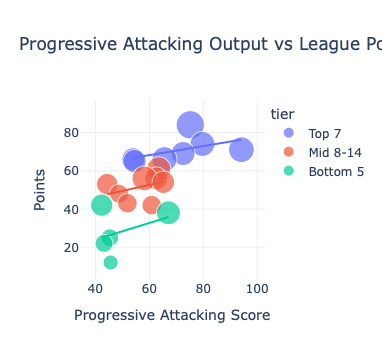

In [115]:
fig = px.scatter(
    master_df,
    x='progressive_attack_score',
    y='points',
    size='goals',
    color='tier',  # or 'points' if you want a gradient
    hover_name='team',
    trendline='ols',
    hover_data={
        'goals': True,
        'conceded': True,
        'possession': True,
        'annual_normalized': True,
        'progressive_attack_score': ':.2f'
    },
    title='Progressive Attacking Output vs League Points'
)

fig.update_layout(
    xaxis_title='Progressive Attacking Score',
    yaxis_title='Points',
    template='plotly_white'
)

fig.show()